For this assignment question we are focussed on image classification problem. We are given 25000 images of labelled cats vs dogs and we are tasked with classifying the test data - which is 12500 unlabelled images.

We follow the metric of accuracy - however the metric in the competition is the closest probability to an actual image.

We will continue to work on a Kaggle notebook this time to make use of the inbuilt GPU as well as large image data that we are seeing. For this reason the path will be associate with Kaggle.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


We can see that we have 3 folders containing data - we can review first the sample submission.csv to understand what type we need our outputs to be. We also load the relevant libraries that we will be using in this

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import zipfile
import glob
import os
import shutil
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
sample_sub = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sample_sub.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


All the folders containing the images are available in a zipped format - we first use the ZipFile library to unzip and store the extracted images

In [4]:
for file_zip in glob.glob('/kaggle/input/dogs-vs-cats-redux-kernels-edition/*.zip'):
    with zipfile.ZipFile(file_zip, 'r') as zip_ref:
        zip_ref.extractall()

We follow this up by making two distinct directories within the train folder for the 2 classes we are trying to classify - cats and dogs

In [5]:
os.mkdir('/kaggle/working/train/cat')
os.mkdir('/kaggle/working/train/dog')

We can now move the images from the train folder to the respective cats/dogs folder below

In [6]:
base_path = '/kaggle/working/train/'
categories = ['cat' , 'dog']
def move_images_to_category(file_path, category):
    for image_name in os.listdir(file_path):
        if category in image_name:
            shutil.move(os.path.join(base_path, image_name), os.path.join(base_path, category))
    
for category in categories:
    move_images_to_category(base_path, category)

We update the image size first to a value of 224 - we will assume square images. 

We also set a roughly high value of epochs and batch size for our first initialization

As the data is very large - previous attempts to run by splitting the data without using DataGenerators led to memory errors. Hence to optimize this we will make use of ImageDataGenerator. We will also make use of the validation data from this training folder to improve our model's learning

In [7]:
image_size = 224
batch_size = 224
epochs = 100
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory('train/', class_mode='binary', batch_size = batch_size, target_size=(image_size,image_size), subset='training', shuffle=True, seed=42)
validation_generator = train_datagen.flow_from_directory('train/', class_mode='binary', batch_size = batch_size, target_size=(image_size,image_size), subset='validation', shuffle=True, seed=42)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Using a 20% split we get 20K images in the training data and 5K images on the validation data

I decided to build a progressive model of CNN assuming 3 layered inputs for the color and then using a combination of filters and maximum pooling together thrice to maximize the performance. I was unable to tune the number of layers due to memory errors

In [8]:
tf.random.set_seed(42)
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters = 32, kernel_size=(3,3), strides=(1,1), activation="relu"))
model.add(Conv2D(filters = 64, kernel_size=(3,3), strides=(1,1), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), strides=(2,2), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters = 256, kernel_size=(3,3), strides=(1,1), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters = 512, kernel_size=(3,3), strides=(1,1),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters = 1024, kernel_size=(2,2), strides=(1,1),activation="relu"))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()

2022-12-04 23:14:09.016465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0

2022-12-04 23:14:09.191065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:14:09.191878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 23:14:09.193455: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 23:14:09.193765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

As a binary classification problem 0 chose the binary cross entropy as my loss function and with my metrics as accuracy - over 2 attempts the adam optimizer returned the best results and hence commented out the optimizer attempt of sgd.

In [9]:
#model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [10]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
              metrics=['accuracy'])

Creating early stopping and model saving parameters at this point. We chose an early stopping point of 5 rounds 

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

save_best = ModelCheckpoint(
filepath = 'model.hdf5',
verbose=-1, save_best_only=True
)

Fitting directly now with the generators we created above and also using the parameters of early stopping and callbacks

In [12]:
history = model.fit(train_generator, validation_data = validation_generator,\
                         epochs = epochs, callbacks=[save_best,early_stopping], verbose=-1)

2022-12-04 23:14:13.130740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-04 23:14:15.639183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100


Plotting below the performance of the loss and accuracy on both training and validation generators. We can see that the validation performance is getting worse which sugggets why the early stop was useful. So we will consider best performance here after 12 rounds.

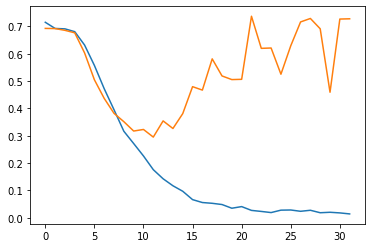

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

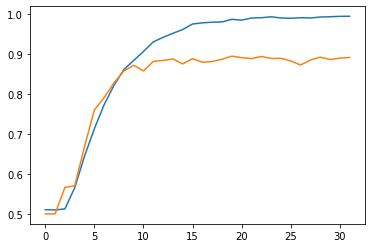

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

We will now save the best model.

In [15]:
best_model = tf.keras.models.load_model('model.hdf5')
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0

Creating a dataframe for testing - which has the file labels and we will impose our predictions on

In [16]:
test_image_files = os.listdir('/kaggle/working/test')
test_df = pd.DataFrame(data = test_image_files, columns = ['filename'])
test_df['id'] = test_df['filename'].apply(lambda f: int(f.split('.')[0]))
test_df.sort_values(by = 'id', inplace = True, ignore_index = True)

We now fit the data but perform test generators on this and then use that to fit our best model on top of it,

In [17]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/kaggle/working/test', 
    x_col='filename',
    class_mode= None,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=False
)
predict = best_model.predict(test_generator, verbose = 1)

Found 12500 validated image filenames.
56/56 [==============================] - 49s 880ms/step


We then follow this up by updating our data and write to a csv which we will submit

In [19]:
test_df["label"] = predict
result = test_df[["id", "label"]]
result.to_csv('Final_submission.csv', index=False)

Below is the screenshot of our best performance here - for your reference.